# Анализ поведения пользователей мобильного приложения

**Цель проекта**

Разобраться, как ведут себя пользователи мобильного приложения стартапа по продаже продуктов питания.

Изучить воронку продаж, узнать, как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на различных шагах.

Исследовать результаты A/A/B-эксперимента после изменения дизайнерами шрифтов в приложении.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Откройте файл с данными и изучите общую информацию

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#загрузим данные
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
print(logs)

                      EventName         DeviceIDHash  EventTimestamp  ExpId
0              MainScreenAppear  4575588528974610257      1564029816    246
1              MainScreenAppear  7416695313311560658      1564053102    246
2       PaymentScreenSuccessful  3518123091307005509      1564054127    248
3              CartScreenAppear  3518123091307005509      1564054127    248
4       PaymentScreenSuccessful  6217807653094995999      1564055322    248
...                         ...                  ...             ...    ...
244121         MainScreenAppear  4599628364049201812      1565212345    247
244122         MainScreenAppear  5849806612437486590      1565212439    246
244123         MainScreenAppear  5746969938801999050      1565212483    246
244124         MainScreenAppear  5746969938801999050      1565212498    246
244125       OffersScreenAppear  5746969938801999050      1565212517    246

[244126 rows x 4 columns]


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
logs.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


In [6]:
#проверим данные на наличие пропусков
logs.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

пропусков в столбцах нет

In [7]:
#проверим данные на наличие явных дубликатов
logs.duplicated().sum()

413

In [8]:
#удалим дубликаты
logs.drop_duplicates(inplace = True)

## Подготовьте данные

In [9]:
#заменим названия столбцов на более привычные
logs.columns=['event_name', 'user_id', 'event_timestamp', 'exp_id']

In [10]:
#изменим формат данных в столбце с датой
logs['event_timestamp'] = logs['event_timestamp'].astype('datetime64[s]')

In [11]:
#добавим столбец даты и времени, а также отдельный столбец дат
logs['date_time'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs['date'] = logs['date_time'].astype('datetime64[D]')

## Изучите и проверьте данные

In [12]:
#узнаем уникальные типы событий
print(logs['event_name'].unique())
print('всего уникальных типов событий в логе:', len(logs['event_name'].unique()))

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
всего уникальных типов событий в логе: 5


In [13]:
print('всего событий в логе:', len(logs['event_name']))

всего событий в логе: 243713


In [14]:
print('количество уникальных пользователей в логе:', len(logs['user_id'].unique()))

количество уникальных пользователей в логе: 7551


In [15]:
print('в среднем на пользователя приходится событий:', round(len(logs['event_name'])/len(logs['user_id'].unique())))

в среднем на пользователя приходится событий: 32


In [16]:
#найдем минимальную и максимальную дату и период между датами
date_min = logs['date_time'].min()
print(date_min)
date_max = logs['date_time'].max()
print(date_max)
diff = date_max - date_min
print(diff)

2019-07-25 04:43:36
2019-08-07 21:15:17
13 days 16:31:41


In [17]:
sns.set(rc={'figure.figsize':(15, 8)})

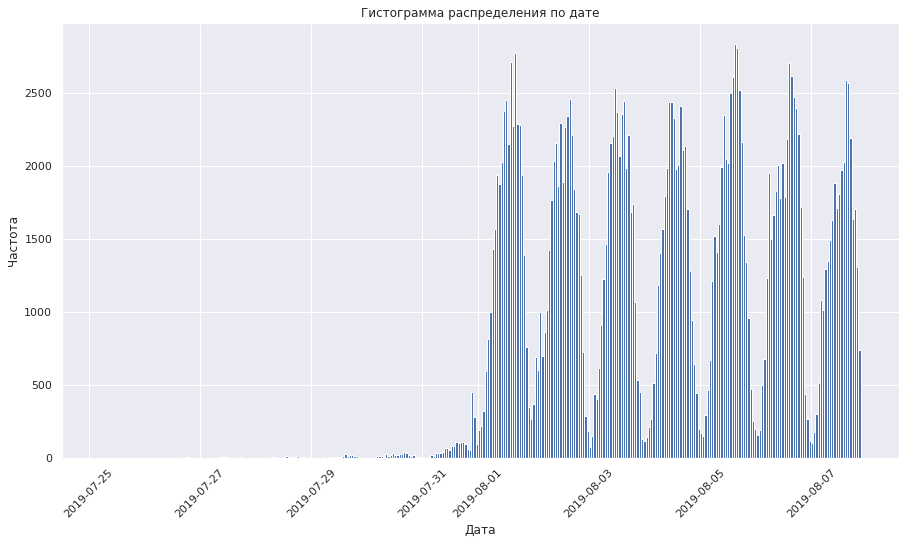

In [18]:
#построим гистограмму распределения по дате
logs['date_time'].hist(bins=14*24)
plt.xticks(rotation=45)
plt.title('Гистограмма распределения по дате')
plt.xlabel("Дата")
plt.ylabel("Частота")
plt.show()

Согласно гистограмме, до 31 июля включительно данных почти нет. Поэтому имеет смысл оставить данные только с 1 августа. Избавимся от данных до 31 июля включительно.

In [19]:
logs = logs.loc[logs['date'] > '2019-07-31']

In [20]:
print('Всего событий в логе после удаления:', logs.shape[0])
print('Количество уникальных пользователей приложения после удаления:', len(logs['user_id'].unique()))
print('После удаления в среднем на пользователя приходится событий:', round(logs.shape[0]/len(logs['user_id'].unique())))

Всего событий в логе после удаления: 240887
Количество уникальных пользователей приложения после удаления: 7534
После удаления в среднем на пользователя приходится событий: 32


In [21]:
#расчитаем % событий после удаления
events_raw = 243713
print('после очистки данных потеряли', round((events_raw - logs.shape[0])/events_raw*100,2), '% событий')

после очистки данных потеряли 1.16 % событий


In [22]:
#расчитаем % пользователей после удаления
users_raw = 7551
print('после очистки данных потеряли', round((users_raw - len(logs['user_id'].unique()))/users_raw*100,2), '% пользователей')

после очистки данных потеряли 0.23 % пользователей


После удаления данных до 31 июля включительно потери составили около 3000 событий и 17 уникальных пользователей, число событий приходящихся в среднем на одного пользователя не изменилось (32 события на пользователя).

In [23]:
#проверим, есть ли у нас пользователи из всех трех групп
logs.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2484
247,2513
248,2537


In [24]:
logs.groupby('exp_id')['user_id'].nunique().sum()

7534

Пользователи из всех трёх экспериментальных групп есть. Пересечений в множествах нет, т.к. сумма количеств уникальных пользователей в трех группах совпадает с количеством уникальных пользователей, которое получилось у нас после удаления данных.

# Вывод 1

После ознакомления с данными выяснилось, что данные представлены с 25 июля по 7 августа. Данные за первую неделю практически отсутствуют. Исходя из этого, были оставлены данные только за вторую неделю, с 1 августа включительно.

Количество уникальных пользователей приложения после удаления составило 7534, в среднем на пользователя приходится 32 события.

В данных есть пользователи всех трех экспериметальных групп, их число примерно равное в каждой группе, все пользователи в группах уникальные, т.е. нет пользователей, которые попали в несколько групп одновременно.

## Изучите воронку событий

In [25]:
#еще раз посмотрим, какие события есть в логах
logs['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [26]:
#Посчитаем, сколько раз было совершено каждое событие, отсортируем по частоте
events_cnt = logs['event_name'].value_counts().reset_index().rename(columns={'index':'event_name', 'event_name':'count'})
events_cnt

,event_name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Имеем следующие события в порядке убывания по частоте:

1. Появление главного экрана

2. Появление экрана с продуктами

3. Появление экрана с корзиной

4. Появление экрана с успешной оплатой

5. Обучение

In [27]:
#посмотрим, сколько уникальных пользователей совершали каждое из событий
event_to_event = logs.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False).rename(columns={'user_id':'unique_users_cnt'})
event_to_event

,event_name,unique_users_cnt
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [28]:
#посчитаем, сколько пришлось уникальных событий на каждого пользователя
unique_events_by_user = logs.groupby('user_id')['event_name'].nunique().reset_index()
unique_events_by_user

,user_id,event_name
0,6888746892508752,1
1,6909561520679493,4
2,6922444491712477,4
3,7435777799948366,1
4,7702139951469979,4
...,...,...
7529,9217594193087726423,3
7530,9219463515465815368,4
7531,9220879493065341500,3
7532,9221926045299980007,1


In [29]:
#посмотрим на долю пользователей, за которыми только одно событие
one_event_users_cnt = unique_events_by_user[unique_events_by_user['event_name'] == 1]['user_id'].count()
one_event_users_ratio = round(one_event_users_cnt/logs['user_id'].nunique(),2)
print('Доля пользователей, совершивших одно событие:', one_event_users_ratio)

Доля пользователей, совершивших одно событие: 0.36


In [30]:
event_to_event['unique_share'] = round(event_to_event['unique_users_cnt']/len(logs['user_id'].unique()),2)
event_to_event

,event_name,unique_users_cnt,unique_share
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


В числе типов событий присутствует обучение. В то же время это событие самое малочисленное по частоте. Логично предположить, что обучение должно предшествовать всем остальным событиям по хронологии, т.к. предназначено оно для ознакомления с приложением на начальном этапе. 

Такжим образом, мы не можем оставить событие обучение для построения воронки, т.к. оно должно идти первым, но в то же время оно самое малочисленное (получится странная воронка).

Думаю, что в проектировании учета событий допущена ошибка, т.к. либо на событии 'обучение' нужно учитывать и тех, кто его прошел, и тех, кто его пропустил, понадеявшись на понятный интерфейс. Тогда мы бы могли понять, сколько пользователей отваливаются, в принципе столкнувшись с возможностью обучения. Либо это событие в принципе не стоит учитывать.


In [31]:
#уберем из данных событие 'обучение'
event_to_event = event_to_event[:4]
event_to_event

,event_name,unique_users_cnt,unique_share
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


In [32]:
#посчитаем конверсию
event_to_event['conversion'] = round(event_to_event['unique_users_cnt'] / event_to_event.iloc[0,1], 2)
event_to_event

,event_name,unique_users_cnt,unique_share,conversion
1,MainScreenAppear,7419,0.98,1.00
2,OffersScreenAppear,4593,0.61,0.62
0,CartScreenAppear,3734,0.50,0.50
3,PaymentScreenSuccessful,3539,0.47,0.48


In [33]:
#добавим поэтапную конверсию
event_to_event['event_to_event_conversion'] = None
event_to_event.iloc[0,4] = 1
event_to_event.iloc[1,4] = round(event_to_event.iloc[1,1] / event_to_event.iloc[0,1], 2)
event_to_event.iloc[2,4] = round(event_to_event.iloc[2,1] / event_to_event.iloc[1,1], 2)
event_to_event.iloc[3,4] = round(event_to_event.iloc[3,1] / event_to_event.iloc[2,1], 2)
event_to_event

,event_name,unique_users_cnt,unique_share,conversion,event_to_event_conversion
1,MainScreenAppear,7419,0.98,1.00,1
2,OffersScreenAppear,4593,0.61,0.62,0.62
0,CartScreenAppear,3734,0.50,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.48,0.95


Больше всего пользователей теряется после первого шага (38% пользователей не дошли до показа экрана с предложениями).

До последнего шага (появления экрана с успешной оплатой) доходят 48% пользователей.

# Вывод 2

В данных есть события 5 типов. Отсортированные по убыванию частоты события выглядят следующим образом:

1. Появление главного экрана

2. Появление экрана с продуктами

3. Появление экрана с корзиной

4. Появление экрана с успешной оплатой

5. Обучение

Т.к. событие обучение должно быть первым по хронологии встречи с пользователем, однако является самым малочисленным по частоте, принято решение не оставлять его для построения воронки.

Если не брать в расчет шаг с обучением, то остальные события выстраиваются по этапам логично: сначала пользователь встречается с главным экраном, затем видит предложения, экран с корзино и экран с успешной оплатой.

После построения воронки можно сделать следующие выводы:

1. Больше всего пользователей теряется после первого шага (38% пользователей не дошли до показа экрана с предложениями). Чем дальше по воронке, тем меньше пользователей теряется. Возможно проблема низкой конверсии на первом шаге в том, что неочевидно, как перейти к ознакомлению с ассортиментом (неудобное меню, незаметная кнопка). 

2. До последнего шага (появления экрана с успешной оплатой) доходят 48% пользователей.

3. 5% пользователей теряется между этапами появление экрана с корзиной и появление экрана с успешной оплатой, что может говорить о возможном наличии технических проблем с оплатой.




## Изучите результаты эксперимента

In [34]:
#переименуем группы в соответствии с названиями групп тестирования - A1, A2 и B
logs['group'] = logs['exp_id'].replace(246, 'A1')
logs['group'] = logs['group'].replace(247, 'A2')
logs['group'] = logs['group'].replace(248, 'B')
logs

,event_name,user_id,event_timestamp,exp_id,date_time,date,group
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01 00:07:28,2019-08-01,A1
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01 00:08:00,2019-08-01,A1
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01 00:08:55,2019-08-01,A1
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01 00:08:58,2019-08-01,A1
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01 00:08:59,2019-08-01,A2
...,...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07 21:12:25,2019-08-07,A2
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07 21:13:59,2019-08-07,A1
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07 21:14:43,2019-08-07,A1
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07 21:14:58,2019-08-07,A1


In [35]:
#еще раз посмотрим, сколько пользователей в каждой группе
users_cnt = logs.groupby('group').agg({'user_id': 'nunique'}).reset_index()
users_cnt

,group,user_id
0,A1,2484
1,A2,2513
2,B,2537


Во всех трех группах примерно одинаковое количество пользователей - около 2500 человек.

In [36]:
#узнаем различие между контрольными группами
A1toA2 = round(100 - users_cnt.iloc[0,1]/users_cnt.iloc[1,1]*100, 2)
print(A1toA2)

1.15


Как мы выяснили ранее, пересечений в пользователях между группами нет, численно группы А1 и А2 различаются на 1.15%, в идеале различие не должно превышать 1%, но наблюдаемое различие не критичное, поэтому делаем вывод, что данные подходят для тестирования.

In [37]:
#добавим строку для общей группы A1+A2
users_cnt.loc[3] = ['A1+A2', users_cnt.iloc[0,1] + users_cnt.iloc[1,1]]
users_cnt

,group,user_id
0,A1,2484
1,A2,2513
2,B,2537
3,A1+A2,4997


In [38]:
#сделаем индексами названия групп
users_cnt = users_cnt.set_index(users_cnt.columns[0])
users_cnt

,user_id
group,
A1,2484
A2,2513
B,2537
A1+A2,4997


In [39]:
#получим таблицу с числом пользователей по каждому событию кроме обучения в разреще групп, а также добавим общую группу для групп A1 и А2
funnels = logs.pivot_table(index='event_name', columns='group',values='user_id',aggfunc='nunique')\
                       .sort_values('A1',ascending=False)
funnels['A1+A2'] = funnels['A1'] + funnels['A2']
funnels.drop(['Tutorial'], inplace=True)
funnels

group,A1,A2,B,A1+A2
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


Проведем A/A-тест о равенствве конверсий между группами для всех 4 событий.

Для проверки гипотезы о равенстве конверсий между группами воспользуется z-критерием c поправкой Бонферрони, так как тест является множественным. Всего будет проведено 16 сравнений (4 группы, 4 события).

Сформулируем гипотезы:

H0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы.
H1 - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [40]:
alpha = 0.05 

def z_test(group1, group2, event, alpha): 
    p1_event = funnels.loc[event, group1]
    p2_event = funnels.loc[event, group2] 
    p1_users = users_cnt.loc[group1, 'user_id'] 
    p2_users = users_cnt.loc[group2, 'user_id'] 
    p1 = p1_event / p1_users 
    p2 = p2_event / p2_users 
    difference = p1 - p2
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    bonferroni_alpha = alpha / 16
    
    print('Тест для групп {} и {}, событие: {}, p-value: {p_value:.2f}'.format(group1, group2, event, p_value=p_value))
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [41]:
for event in funnels.index:
    z_test('A1', 'A2', event, 0.05)
    print()

Тест для групп A1 и A2, событие: MainScreenAppear, p-value: 0.76
Не получилось отвергнуть нулевую гипотезу

Тест для групп A1 и A2, событие: OffersScreenAppear, p-value: 0.25
Не получилось отвергнуть нулевую гипотезу

Тест для групп A1 и A2, событие: CartScreenAppear, p-value: 0.23
Не получилось отвергнуть нулевую гипотезу

Тест для групп A1 и A2, событие: PaymentScreenSuccessful, p-value: 0.11
Не получилось отвергнуть нулевую гипотезу



По результатам A/A-теста нельзя сделать вывод о различии конверсий между контрольными группами А1 и А2 по всем 4 событиям.

Проведем А/B-тест, поочередно сравним конверсии группы B c группами А1, А2 и объединенной группой B для всех 4 событий.

Сформулируем гипотезы:

Гипотеза H0: Конверсия пользователей в обеих группах равна

Гипотеза H1: Конверсия пользователей в обеих группах не равна

In [42]:
#группы А1 и В
for event in funnels.index:
    z_test('A1', 'B', event, 0.05)
    print()

Тест для групп A1 и B, событие: MainScreenAppear, p-value: 0.29
Не получилось отвергнуть нулевую гипотезу

Тест для групп A1 и B, событие: OffersScreenAppear, p-value: 0.21
Не получилось отвергнуть нулевую гипотезу

Тест для групп A1 и B, событие: CartScreenAppear, p-value: 0.08
Не получилось отвергнуть нулевую гипотезу

Тест для групп A1 и B, событие: PaymentScreenSuccessful, p-value: 0.21
Не получилось отвергнуть нулевую гипотезу



Нельзя сделать вывод о различии конверсий между группами А1 и B по всем 4 событиям.

In [43]:
#группы А2 и В
for event in funnels.index:
    z_test('A2', 'B', event, 0.05)
    print()

Тест для групп A2 и B, событие: MainScreenAppear, p-value: 0.46
Не получилось отвергнуть нулевую гипотезу

Тест для групп A2 и B, событие: OffersScreenAppear, p-value: 0.92
Не получилось отвергнуть нулевую гипотезу

Тест для групп A2 и B, событие: CartScreenAppear, p-value: 0.58
Не получилось отвергнуть нулевую гипотезу

Тест для групп A2 и B, событие: PaymentScreenSuccessful, p-value: 0.74
Не получилось отвергнуть нулевую гипотезу



Нельзя сделать вывод о различии конверсий между группами А2 и B по всем 4 событиям.

In [44]:
#группы A1+А2 и В
for event in funnels.index:
    z_test('A1+A2', 'B', event, 0.05)
    print()

Тест для групп A1+A2 и B, событие: MainScreenAppear, p-value: 0.29
Не получилось отвергнуть нулевую гипотезу

Тест для групп A1+A2 и B, событие: OffersScreenAppear, p-value: 0.43
Не получилось отвергнуть нулевую гипотезу

Тест для групп A1+A2 и B, событие: CartScreenAppear, p-value: 0.18
Не получилось отвергнуть нулевую гипотезу

Тест для групп A1+A2 и B, событие: PaymentScreenSuccessful, p-value: 0.60
Не получилось отвергнуть нулевую гипотезу



Нельзя сделать вывод о различии конверсий между группами А1+А2 и B по всем 4 событиям.

# Вывод 3

Исходя из тестов, пока изменение шрифтов никак не повлияло на пользователей.

В этой связи можно сделать 2 вывода, исходя из целеполагания изменения шрифтов.

1. Если шрифты менялись целенаправленно, и менялись только они, чтобы, например, сделать заметнее раздел с ассортиментом для перехода в него с основной страницы и т.д., то есть для повышения конверсий на разных этапах, то пока это не дало эффекта.

2. Если шрифты меняются в рамках комплексного проекта по улучшению интерфейса приложения, и начали по какой-то причине именно с них, тогда, возможно, при условии что проект предполагает еще ряд этапов после изменения шрифтов, итог может быть успешным. Пока, по крайней мере, хуже не стало. А последующие этапы проекта + замена шрифтов, возможно, дадут кумулятивный положительный эффект.

Всего было сделано 16 проверок статистических гипотез, был выбран уровень значимости в 5% с поправкой Бонферрони, т.к. тест был множественным.